In [1]:
import fastbook
fastbook.setup_book()
from fastbook import *

from fastai.tabular.all import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from dtreeviz.trees import *

# Chapter 8: tabular models

In [2]:
path = Path('data/bulldozer')

In [3]:
df = pd.read_csv(path/'TrainAndValid.csv')
df.head()

/opt/conda/envs/fastai/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (13,39,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metric Tons",Texas,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Features

In [4]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

### Ordering

Some categorical features have a natural ordering:

In [5]:
df.ProductSize.unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [6]:
sizes = ['Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']
df.ProductSize = df.ProductSize.astype('category')
df.ProductSize.cat.set_categories(sizes, ordered=True, inplace=True)

### Dates

fastai has a generic method that extracts lots of categorical information about a numerical date.

In [7]:
df = add_datepart(df, 'saledate')

In [8]:
[c for c in df.columns if c.startswith('sale')]

['saleWeek',
 'saleYear',
 'saleMonth',
 'saleDay',
 'saleDayofweek',
 'saleDayofyear',
 'saleIs_month_end',
 'saleIs_month_start',
 'saleIs_quarter_end',
 'saleIs_quarter_start',
 'saleIs_year_end',
 'saleIs_year_start',
 'saleElapsed']

### Further preprocessing

For cleanup:

In [9]:
procs = [Categorify, FillMissing]

For a sensible split into the validation set:

In [10]:
condition = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where(condition)[0]
valid_idx = np.where(~condition)[0]

splits = (list(train_idx), list(valid_idx))

This kaggle competition says the metric should be RLMSE. We can achieve that by taking the log of the dependent variable now and later use the standard RMSE.

In [11]:
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

Lastly, the categories:

In [12]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

### DataLoader

In [13]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [14]:
len(to.train), len(to.valid)

(404710, 7988)

In [15]:
to.show(3)

,saleWeek,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear,SalePrice
0,46,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1163635200,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,16,3,320,11.097410
1,13,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1080259200,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,26,4,86,10.950807
2,9,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,1077753600,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,26,3,57,9.210340


In [16]:
to.items.head(3)

,SalesID,SalePrice,MachineID,saleWeek,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,46,3157,121,3.0,2004,68.0,2,963,298,43,0,0,0,59,1,6,6,0,3,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,2006,11,16,3,320,1,1,1,1,1,1,2647,1,1
1,1139248,10.950807,117657,13,77,121,3.0,1996,4640.0,2,1745,529,57,104,0,3,62,33,6,6,0,3,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,12,3,0,0,0,0,0,0,0,0,0,0,0,0,4,2,2004,3,26,4,86,1,1,1,1,1,1,2148,1,1
2,1139249,9.210340,434808,9,7009,121,3.0,2001,2838.0,1,336,111,0,0,0,0,39,32,3,3,0,6,1,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,1,1,3,0,0,0,0,0,0,0,0,0,0,0,2004,2,26,3,57,1,1,1,1,1,1,2131,1,1


In [17]:
pickle.dump(to, (path/'to.pkl').open('wb'))

# Decision tree

In [18]:
to = pickle.load((path/'to.pkl').open('rb'))
to.show(3)

,saleWeek,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear,SalePrice
0,46,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1163635200,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,16,3,320,11.097410
1,13,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,1080259200,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,26,4,86,10.950807
2,9,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,1077753600,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,26,3,57,9.210340


In [19]:
xs = to.train.xs
y = to.train.y

valid_xs = to.valid.xs
valid_y = to.valid.y

In [20]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=4)

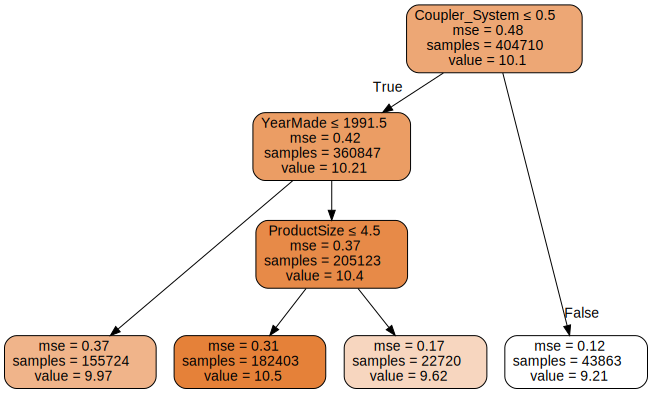

In [21]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

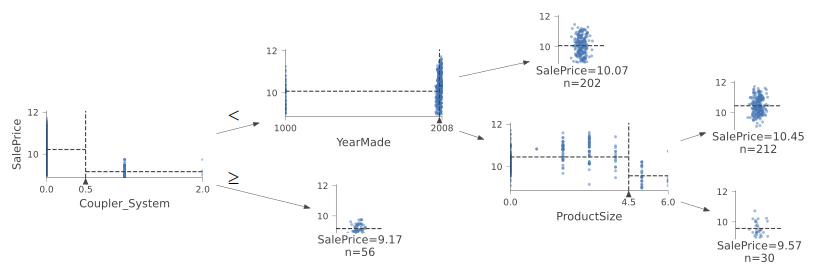

In [22]:
samp_idx = np.random.permutation(len(y))[:500]
dep_var = 'SalePrice'
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var, fontname='DejaVu Sans', scale=1.5, orientation='LR', label_fontsize=10)

A YearMade of 1000 is probably the way to mark missing values in this dataset. Let's replace it with 1950 to make visualization easier.

In [23]:
xs.loc[xs.YearMade<1950, 'YearMade'] = 1950
valid_xs.loc[valid_xs.YearMade<1950, 'YearMade'] = 1950

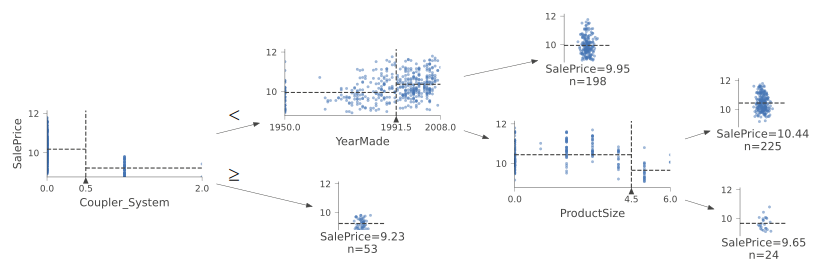

In [24]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)
samp_idx = np.random.permutation(len(y))[:500]
dep_var = 'SalePrice'
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var, fontname='DejaVu Sans', scale=1.5, orientation='LR', label_fontsize=10)

In [25]:
def r_mse(pred, y): return np.round(np.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [26]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.55325, 0.55646)

In [27]:
m = DecisionTreeRegressor().fit(xs, y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.0, 0.331388)

In [28]:
m = DecisionTreeRegressor(min_samples_leaf=25).fit(xs, y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.211701, 0.268533)

# Random Forest

In [29]:
def rf(xs, y, n_estimators=40, max_samples=200_000, max_features=.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators, max_samples=max_samples, max_features=max_features,
                                min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [30]:
m = rf(xs, y)

In [31]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.17125, 0.233814)

In [32]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
r_mse(preds.mean(0), valid_y)

0.233814

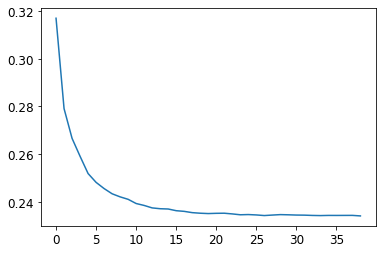

In [33]:
plt.plot([r_mse(preds[:i].mean(0), valid_y) for i in range(1,40)]);

## OOB score

In [34]:
r_mse(m.oob_prediction_, y)

0.211118

# Model interpretation

## Tree variance

Comparing the confidenc of two predictions can be done via the variance of the trees predictions.

In [35]:
preds.std(0)[:5]

array([0.22468614, 0.11493139, 0.0905831 , 0.23564683, 0.14912952])

## Feature importance

Is already a attribute of a sklearn random forest.

In [36]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

In [37]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
59,YearMade,0.178611
7,ProductSize,0.122824
31,Coupler_System,0.116004
8,fiProductClassDesc,0.069670
56,ModelID,0.057168
51,saleElapsed,0.051300
32,Grouser_Tracks,0.040190
4,fiSecondaryDesc,0.038877
33,Hydraulics_Flow,0.037397
2,fiModelDesc,0.032815


In [38]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

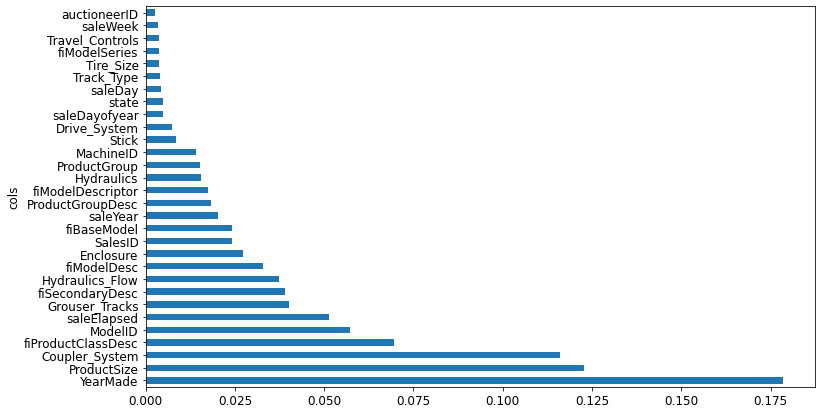

In [39]:
plot_fi(fi[:30]);

### Removing low-importance variables

In [40]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

21

In [41]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

m = rf(xs_imp, y)

In [42]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.181765, 0.231212)

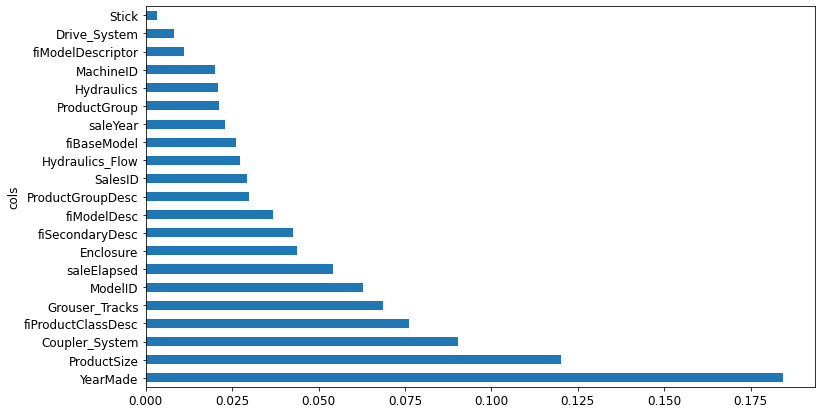

In [43]:
plot_fi(rf_feat_importance(m, xs_imp));

## Redundant features

Find redundancies with spearman correlation.

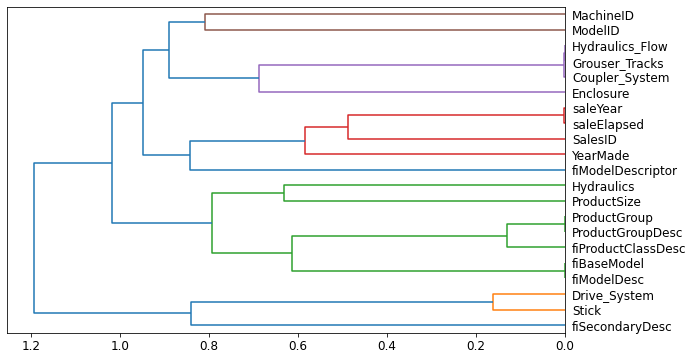

In [44]:
cluster_columns(xs_imp)

In [45]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
                             max_samples=50000, max_features=.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [46]:
get_oob(xs_imp)

0.8772113461561863

Now remove one column of the closely correlated ones, one at a time:

In [47]:
{c : get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc', 'ProductGroup',
'fiModelDesc', 'fiBaseModel', 'Hydraulics_Flow', 'Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8770276370297958,
 'saleElapsed': 0.8728588283578091,
 'ProductGroupDesc': 0.8774835314625554,
 'ProductGroup': 0.8765963547836646,
 'fiModelDesc': 0.8758758214942426,
 'fiBaseModel': 0.8761266559115268,
 'Hydraulics_Flow': 0.8773844457239098,
 'Grouser_Tracks': 0.8771408000124103,
 'Coupler_System': 0.8771382752267984}

In [48]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8745952852230139

In [49]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

pickle.dump(xs_final, (path/'xs_final.pkl').open('wb'))
pickle.dump(valid_xs_final, (path/'valid_xs_final.pkl').open('wb'))

In [50]:
valid_xs_final.shape

(7988, 17)

##### Load

In [51]:
xs_final = pickle.load((path/'xs_final.pkl').open('rb'))
valid_xs_final = pickle.load((path/'valid_xs_final.pkl').open('rb'))

In [52]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.183433, 0.231551)

## Partial dependence

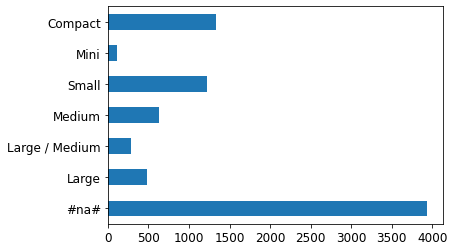

In [53]:
p = valid_xs_final.ProductSize.value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

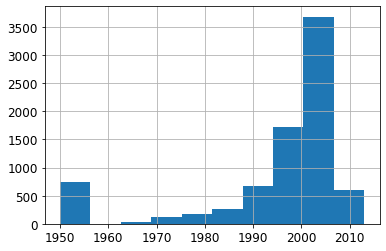

In [54]:
ax = valid_xs_final.YearMade.hist()

In [55]:
from sklearn.inspection import plot_partial_dependence

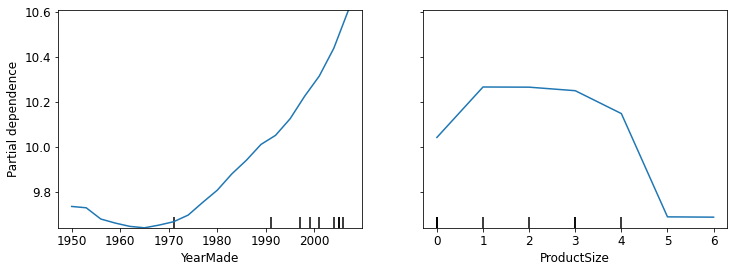

In [56]:
fig, ax = plt.subplots(figsize=(12,4))

plot_partial_dependence(m, valid_xs_final, ['YearMade', 'ProductSize'], grid_resolution=20, ax=ax);

## Tree interpreter

In [57]:
from treeinterpreter import treeinterpreter
import waterfall_chart

/opt/conda/envs/fastai/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


Feature importance for a single row.

In [58]:
row = valid_xs_final.iloc[:5]
predictions, bias, contributions = treeinterpreter.predict(m, row.values)

In [59]:
predictions[0], bias[0], contributions[0].sum()

(array([9.98268631]), 10.10430126604569, -0.12161495749984459)

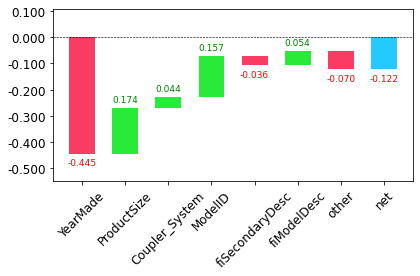

In [60]:
waterfall_chart.plot(valid_xs_final.columns, contributions[0], threshold=.08, rotation_value=45, formatting='{:,.3f}');

# Extrapolation problem

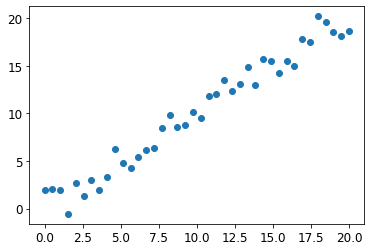

In [61]:
x_lin = torch.linspace(0, 20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin);

In [62]:
xs_lin = x_lin.unsqueeze(-1)

In [63]:
m_lin = RandomForestRegressor().fit(xs_lin[:30], y_lin[:30])

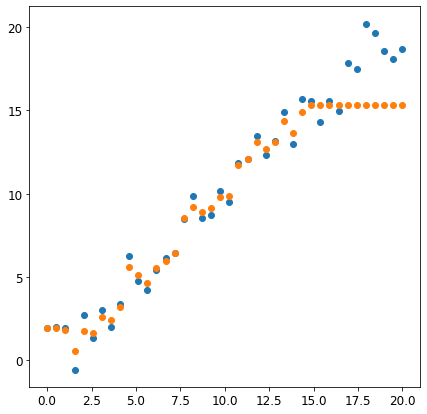

In [64]:
fig, ax = plt.subplots(figsize=(7,7))

ax.scatter(x_lin, y_lin)
ax.scatter(x_lin, m_lin.predict(xs_lin))

plt.show()

### Out-of-domain data

In [65]:
df_domain = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_domain, is_valid)

In [66]:
rf_feat_importance(m, df_domain)[:6]

,cols,imp
5,saleElapsed,0.857707
10,SalesID,0.118486
14,MachineID,0.019655
0,YearMade,0.001027
4,ModelID,0.000569
8,fiModelDesc,0.000504


The top 3 features seem to change from training to validation set. What happens when we remove them?

In [67]:
m_rmse(m, df_domain, is_valid)

0.002182

In [68]:
for c in ['saleElapsed', 'SalesID', 'MachineID']:
    m = rf(xs_final.drop(c, axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c, axis=1), valid_y))

saleElapsed 0.235061
SalesID 0.23026
MachineID 0.231098


In [69]:
m = rf(xs_final, y)
m_rmse(m, valid_xs_final, valid_y)

0.231599

Seems like we can remove SalesID and MachineID:

In [70]:
time_vars = ['SalesID', 'MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_final_time = valid_xs_final.drop(time_vars, axis=1)

In [71]:
m = rf(xs_final_time, y)
m_rmse(m, valid_final_time, valid_y)

0.230372

#### Don't use too old data

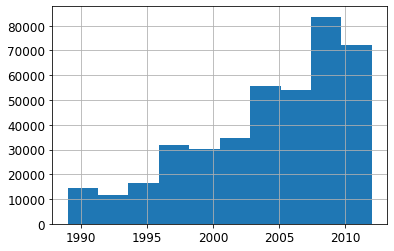

In [72]:
xs.saleYear.hist();

In [73]:
new_mask = xs.saleYear>2004

new_xs = xs_final_time[new_mask]
new_y = y[new_mask]

In [74]:
m = rf(new_xs, new_y)
m_rmse(m, valid_final_time, valid_y)

0.22973

# Neural nets

In [75]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

df.ProductSize = df.ProductSize.astype('category')
df.ProductSize.cat.set_categories(sizes, ordered=True, inplace=True)
df[dep_var] = np.log(df[dep_var])
df = add_datepart(df, 'saledate')

In [77]:
df = df[list(xs_final_time.columns) + [dep_var]]

In [78]:
cont_nn, cat_nn = cont_cat_split(df, max_card=9000, dep_var=dep_var)

In [79]:
cont_nn.append('saleElapsed')
cat_nn.remove('saleElapsed')

In [80]:
df[cat_nn].nunique()

YearMade                73
ProductSize              6
Coupler_System           2
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
Hydraulics_Flow          3
fiModelDesc           5059
Enclosure                6
fiModelDescriptor      140
Hydraulics              12
ProductGroup             6
Stick                    2
Drive_System             4
dtype: int64

In [81]:
cat_nn.remove('fiModelDescriptor')

In [89]:
df.saleElapsed = df.saleElapsed.astype(int)

In [92]:
procs = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df, procs, cat_nn, cont_nn, splits=splits, y_names=dep_var)
dls = to_nn.dataloaders(1024)

In [93]:
y = to_nn.train.y
y.min(), y.max()

(8.465899, 11.863583)

In [94]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250], n_out=1, loss_func=F.mse_loss)

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=0.0002754228771664202)

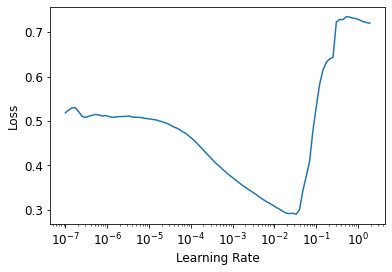

In [95]:
learn.lr_find()

In [96]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.069179,0.061185,00:07
1,0.056429,0.055988,00:07
2,0.048583,0.054040,00:07
3,0.043566,0.050942,00:08
4,0.040477,0.050865,00:07


In [97]:
preds, targets = learn.get_preds()

In [99]:
r_mse(preds, targets)

tensor(0.2255)

In [100]:
learn.save('tabular_nn')

Path('models/tabular_nn.pth')

In [103]:
??TabularModel

In [109]:
rf_preds = m.predict(valid_final_time)
bagged_preds = (to_np(preds.squeeze())+rf_preds)/2

In [111]:
r_mse(bagged_preds, valid_y)

0.222178